# Demo: Serenity VaR Calculation API

In addition to supporting risk attribution, the latest version of Serenity also supports running VaR calculations
and backtesting those VaR models with your portfolio. This notebook will show you how to select a VaR model and
use it to compute Value at Risk (VaR) for a portfolio constructed from the Serenity security master.

In [1]:
%%capture --no-stderr --no-display
%load_ext autoreload
%autoreload 2
%run var_api_helper.py
%run -i init_demo.py 

Output()

To run a VaR calculation the first thing we need is a portfolio:

In [2]:
asset_master = api.refdata().load_asset_master()

portfolio_raw = {
    'BTC': 100,
    'ETH': 1000,
    'SOL': 10000,
    'BNB': 50000
}
portfolio = asset_master.create_portfolio(portfolio_raw, symbology='NATIVE')

The next thing we need is a model configuration. IMPORTANT: this feature is not yet supported in production, but we are including it here because this is the pattern you will need to follow going forward:

In [3]:
from serenity_sdk.types.common import CalculationContext

model_short_name = 'risk.var.parametric.normal'  
model_meta = api.model().load_model_metadata(datetime.date.today())
model_config_id = model_meta.get_model_configuration_id(model_short_name)

Now that we have it we can create the `CalculationContext`, the same as with risk attribution. We will set an as-of-date and pass our parametric VaR model configuration ID. We then run VaR for a given date:

In [4]:
from datetime import date

# construct the input parameters for VaR
ctx = CalculationContext(as_of_date=date(2020, 5, 1), model_config_id=model_config_id)

# run the VaR calc
result = api.risk().compute_var(ctx, portfolio)
result

VaRAnalysisResult(run_date=datetime.datetime(2020, 5, 1, 0, 0), baseline=1947095.4205477787, quantiles=[VaRQuantile(quantile=95.0, var_absolute=132621.984375, var_relative=-0.06811273097991943), VaRQuantile(quantile=97.5, var_absolute=158530.390625, var_relative=-0.08141891658306122), VaRQuantile(quantile=99.0, var_absolute=188654.546875, var_relative=-0.09689024090766907)], excluded_assets=[UUID('9111a3cf-51de-4c9b-ad18-f140353374cb')], warnings=[])

We can also run a backtest:

In [5]:
bt_quantiles = [1, 5, 95, 99]
result = api.risk().compute_var_backtest(ctx, portfolio, date(2020, 5, 1), date(2022, 5, 1), quantiles=bt_quantiles)

In [6]:
# unpack into time series so that it is easier to work with
breach_count_period = 365
(baselines, 
vars_abs_by_qs, vars_rel_by_qs, 
pnls_abs, pnls_rel, 
var_breaches, rolling_breaches) = convert_to_timeseries(result, bt_quantiles, breach_count_period)

# Peeking at results

In [7]:
# Select quantile
q = 99

run_date_col = 'run date'
base_line_col = 'baseline'
var_col = f'{q}%-VaR'
var_rel_col = f'{q}%-VaR (relative)'
pnl_col = 'P&L'
breach_col = 'Breach'
backtest_df = pd.DataFrame({
    run_date_col: pd.to_datetime(baselines.index), 
    base_line_col: baselines, 
    var_col: vars_abs_by_qs[q], 
    var_rel_col: vars_rel_by_qs[q], 
    pnl_col: pnls_abs, 
    breach_col: var_breaches[q]
}).set_index(run_date_col)


loss_fmt = lambda val: f'${val:,.2f}' if val >= 0 else f'(${abs(val):,.2f})'
pct_fmt = lambda val: f'({abs(val):,.1%})' if val < 0 else f'{abs(val):,.1%}'

red_blue_formatter = lambda val: 'color: blue' if val > 0 else 'color: red'
backtest_df.head().style.format({
  base_line_col: loss_fmt,
  var_col: loss_fmt,
  var_rel_col: pct_fmt,
  pnl_col: loss_fmt
}).applymap(red_blue_formatter, subset=[pnl_col])

,baseline,99%-VaR,99%-VaR (relative),P&L,Breach
run date,,,,,
2020-05-01 00:00:00,"$1,954,192.42","$189,648.28",(9.7%),"$23,462.30",False
2020-05-02 00:00:00,"$1,977,654.72","$191,503.89",(9.7%),"($27,342.81)",False
2020-05-03 00:00:00,"$1,950,311.91","$188,598.94",(9.7%),"($5,207.21)",False
2020-05-04 00:00:00,"$1,945,104.71","$187,755.45",(9.7%),"($5,077.47)",False
2020-05-05 00:00:00,"$1,940,027.24","$186,925.89",(9.6%),"$33,913.23",False


# Breaches
And we can identify the breach dates:

In [8]:
backtest_df[backtest_df[breach_col]].head().style.format({
  base_line_col: loss_fmt,
  var_col: loss_fmt,
  var_rel_col: pct_fmt,
  pnl_col: loss_fmt
}).applymap(red_blue_formatter, subset=[pnl_col])

,baseline,99%-VaR,99%-VaR (relative),P&L,Breach
run date,,,,,
2020-05-09 00:00:00,"$2,052,364.13","$196,272.61",(9.6%),"($222,172.12)",True
2020-09-04 00:00:00,"$2,538,239.45","$224,395.55",(8.8%),"($256,120.65)",True
2020-11-25 00:00:00,"$4,119,507.91","$349,528.09",(8.5%),"($483,925.62)",True
2021-01-10 00:00:00,"$7,131,763.76","$599,983.94",(8.4%),"($740,417.64)",True
2021-02-19 00:00:00,"$23,716,701.73","$2,455,738.00",(10.4%),"($3,122,572.89)",True


Now let's do some charting with the backtest data; this is a sneak peek at the kinds of visualizations we will be offering in the Serenity front-end at the end of 2022:

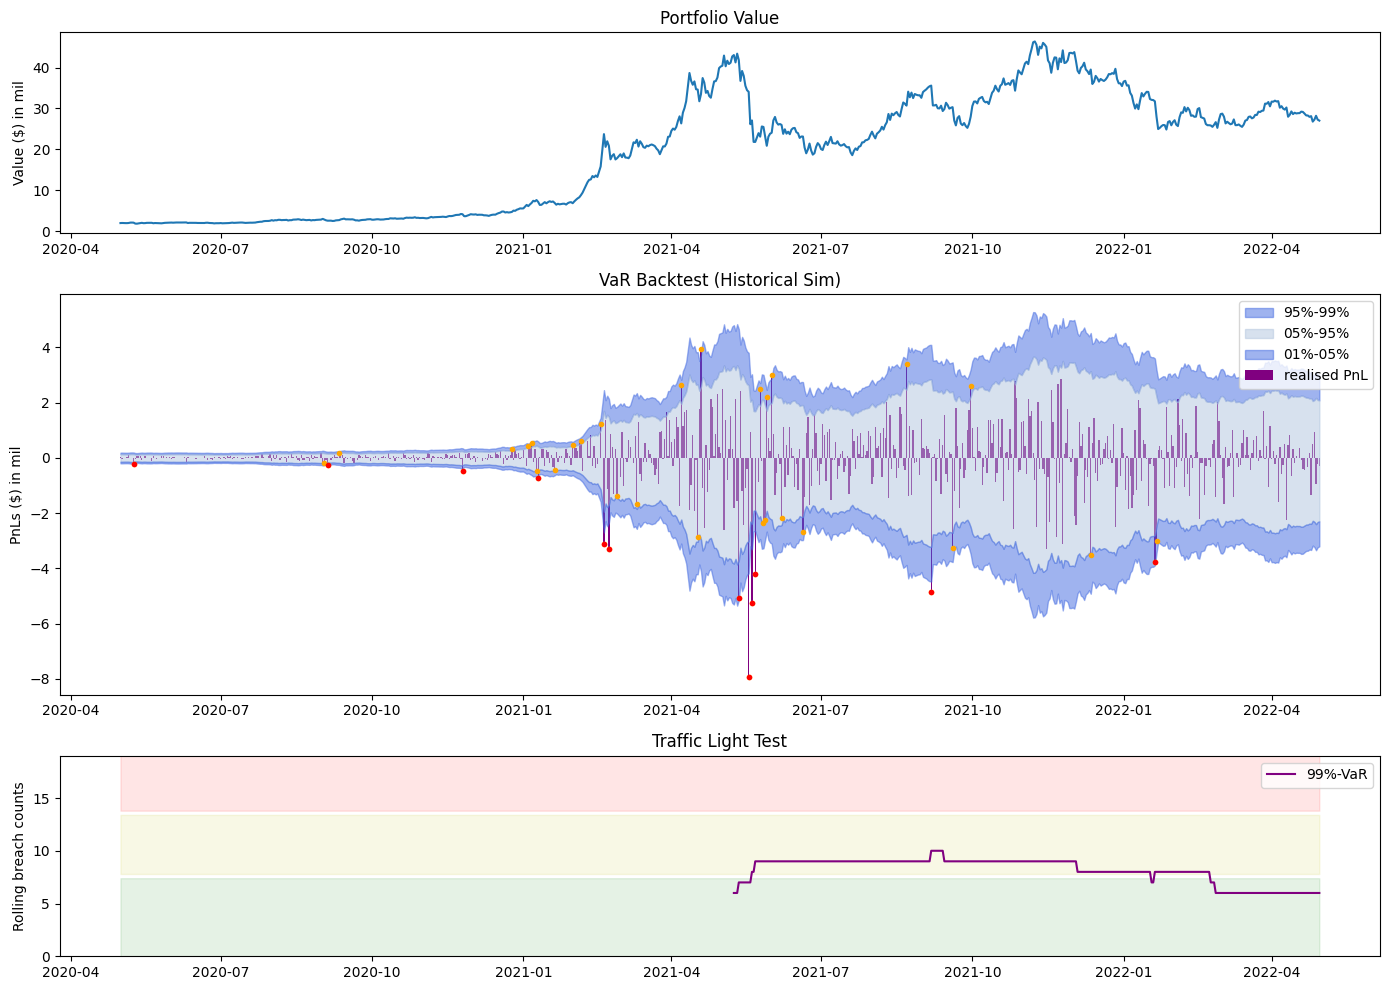

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import binom

kind = "Historical Sim"

scale_unit, scale = 'mil', 1e-6

# convert to pd.Timestamp to date time to ease plotting
dt_index = pd.to_datetime(baselines.index)

fig, axs = plt.subplots(3, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 2, 1]}, sharex=True)

## Portfolio Value Profile
ax0 = axs[0]
ax0.set_title(f"Portfolio Value")
ax0.set_ylabel(f"Value ($) in {scale_unit}")
ax0.plot(dt_index, scale * baselines)
ax0.xaxis.set_tick_params(labelbottom=True)


# VaR & PnL profiles
# Plot in P&L terms. So, VaR will be on the negative side. 
ax1 = axs[1]

nvars_ws = scale * vars_abs_by_qs
pnls_abs_ws = scale * pnls_abs

ax1.set_title(f"VaR Backtest ({kind})")
ax1.set_ylabel(f"PnLs ($) in {scale_unit}")

ax1.bar(dt_index, pnls_abs_ws, lw = 0.5, color="purple", label="realised PnL")
ax1.fill_between(dt_index, nvars_ws[99], nvars_ws[95], alpha=0.5, color="royalblue", label="95%-99%")
ax1.fill_between(dt_index, nvars_ws[95], nvars_ws[5], alpha=0.5, color="lightsteelblue", label="05%-95%")
ax1.fill_between(dt_index, nvars_ws[5], nvars_ws[1], alpha=0.5, color="royalblue", label="01%-05%")

for q in bt_quantiles:
    q_breaches = var_breaches[q]
    color = 'r' if q in [1,99] else 'orange'
    ax1.plot(dt_index[q_breaches], pnls_abs_ws[q_breaches], '.', color=color) #, markersize=5)

ax1.plot()
ax1.legend()
ax1.xaxis.set_tick_params(labelbottom=True)

## Now, traffic light
ax2 = axs[2]
ax2.set_title('Traffic Light Test')
ax2.set_ylabel('Rolling breach counts')

q_rolling = 99
for q in [q_rolling]: #[100-q_rolling, q_rolling]:
    line_style = '-' if q > 50 else '--'
    ax2.plot(dt_index, rolling_breaches[q], ls = line_style, color = 'purple', label=f'{q}%-VaR')
ax2.legend()

x = np.arange(0, breach_count_period)
green_amber, amber_red = [np.min(x[1 - binom.cdf(x, breach_count_period, 1.0-q_rolling/100.) < cf]) for cf in [0.05, 0.0001]]
y_max = amber_red + (amber_red - green_amber)
ax2.fill_between(dt_index, 0.0, green_amber + .4, color='g', alpha=0.1)
ax2.fill_between(dt_index, green_amber + .8, amber_red + .4, color='y', alpha=0.1)
ax2.fill_between(dt_index, amber_red + .8, y_max, color='r', alpha=0.1)
ax2.set_ylim([0.0, y_max])

plt.tight_layout()
plt.show()